In [1]:
import heeps
from heeps.util.img_processing import resize_cube
from heeps.util.coord import cart_coord
from heeps.util.multiCPU import multiCPU
from astropy.io import fits
import os.path
import numpy as np
import proper
import matplotlib.pyplot as plt
%matplotlib inline

## Input parameters

In [2]:
npupil_L = 285              # L band
npupil_N = 119              # N2 band
nimg = 720
pupil_img_size = 39.9988
ax, ay = (-14.642, -55.812) # A0
bx, by = (  0.739, -75.899) # B2
cx, cy = (  5.691, -65.735) # C1
dx, dy = ( 15.628, -45.397) # D0
AT_rad = 1.8/2              # AT radius
AT_rot = -8.5               # AT rotation in deg
RMS_WV_L = 90
RMS_WV_N = 1000
dir_current = '$HOME/heeps_metis'
scao = 'input_files/wavefront/cube_Cbasic_20210504_600s_100ms_0piston_meters_scao_only_%s_WV.fits'%nimg
mask = 'input_files/wavefront/mask_Cbasic_20210504_%s.fits'%nimg
dir_current = os.path.normpath(os.path.expandvars(dir_current))
cube = fits.getdata(os.path.join(dir_current, scao))
pup = fits.getdata(os.path.join(dir_current, mask))
pup[pup < .5] = np.nan

## AT coordinates

In [3]:
# find circumcenter and translate
d = 2 * (ax * (by - dy) + bx * (dy - ay) + dx * (ay - by))
ux = ((ax**2 + ay**2) * (by - dy) + (bx**2 + by**2) * (dy - ay) + (dx**2 + dy**2) * (ay - by)) / d
uy = ((ax**2 + ay**2) * (dx - bx) + (bx**2 + by**2) * (ax - dx) + (dx**2 + dy**2) * (bx - ax)) / d
ATs = np.array([[ax, ay], [bx, by], [cx, cy], [dx, dy]]) - [ux, uy]
# rotate to fit in ELT M1
t = np.deg2rad(AT_rot)
ATs = np.array([(x*np.cos(t) - y*np.sin(t), x*np.sin(t) + y*np.cos(t)) for x,y in ATs])
print('AT coords:\n%s'%ATs)

AT coords:
[[-17.19345442   4.94727687]
 [ -4.95044907 -17.19254133]
 [  1.44949234  -7.8721363 ]
 [ 14.28349078  10.77368621]]


## Create subapertures

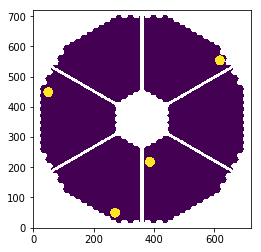

In [4]:
XY = np.array(cart_coord(nimg), ndmin=4)*pupil_img_size/2
XY = (XY.T - ATs.T).T
apers = np.abs(XY[:,0] + 1j*XY[:,1])
apers = (apers <= AT_rad).astype(int)
apers_ATs = np.sum(apers, 0) + pup
fits.writeto(os.path.join(dir_current, 'output_files/apers_ATs.fits'), np.float32(apers_ATs), overwrite=True)
plt.imshow(apers_ATs, origin=True);

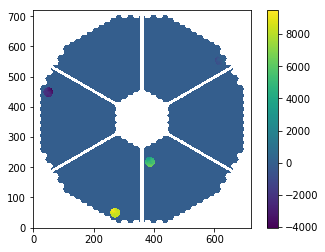

In [5]:
cube0 = cube*1e9 # in nm
apers_ATs_phase = np.sum(apers, 0)*cube0[0] + pup
fits.writeto(os.path.join(dir_current, 'output_files/apers_ATs_phase.fits'), np.float32(apers_ATs_phase), overwrite=True)
plt.imshow(apers_ATs_phase, origin=True), plt.colorbar();

## Temporal RMS on MATISSE bases

In [6]:
def get_piston(frame):
    return np.mean(frame[frame!=0])
def get_rms(frame):
    return np.std(frame[frame!=0])

   2021-05-11 10:14:19, get piston using 12 cores
   2021-05-11 10:35:28, completed in 1269.31 seconds
   2021-05-11 10:36:00, get piston using 12 cores
   2021-05-11 10:57:00, completed in 1260.6 seconds
   2021-05-11 10:57:50, get piston using 12 cores
   2021-05-11 11:17:27, completed in 1177.24 seconds
   2021-05-11 11:18:17, get piston using 12 cores
   2021-05-11 11:38:51, completed in 1233.79 seconds
temporal rms (nm) = [10092.1   9346.19 10938.94  6282.22 13113.56  9775.99]
mean temporal rms = 9924.83 nm


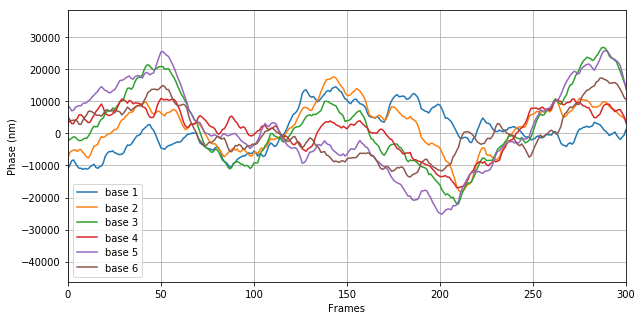

In [7]:
pistons = np.empty((len(apers), len(cube0)))
for i, aper in enumerate(apers):
    pistons[i,:] = multiCPU(get_piston, posvars=[aper*cube0], case='get piston')
OPDs = np.array([pistons[0,:] -  pistons[1,:],
                 pistons[0,:] -  pistons[2,:],
                 pistons[0,:] -  pistons[3,:],
                 pistons[1,:] -  pistons[2,:],
                 pistons[1,:] -  pistons[3,:],
                 pistons[2,:] -  pistons[3,:]])
RMS = np.std(OPDs, 1)
print('temporal rms (nm) = %s\nmean temporal rms = %s nm'%(np.round(RMS, 2), np.round(np.mean(RMS), 2)))
plt.figure(figsize=(10, 5))
for i, OPD in enumerate(OPDs):
    plt.plot(OPD, label='base %s'%(i+1))
plt.xlim(0,300)
plt.legend()
plt.xlabel('Frames')
plt.ylabel('Phase (nm)')
plt.grid(True), plt.grid(which='minor', linestyle=':');

## Spatial RMS

   2021-05-11 11:38:53, get rms using 12 cores
   2021-05-11 11:43:09, completed in 256.21 seconds
mean spatial rms = 5708.14 nm


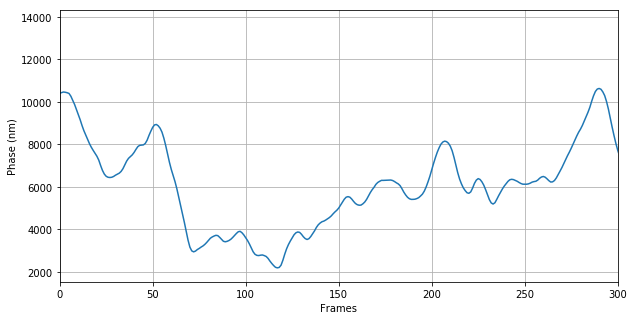

In [8]:
spatial_RMS = multiCPU(get_rms, posvars=[cube0], case='get rms')
print('mean spatial rms = %s nm'%np.round(np.mean(spatial_RMS), 2))
plt.figure(figsize=(10, 5))
plt.plot(spatial_RMS)
plt.xlim(0,300)
plt.xlabel('Frames')
plt.ylabel('Phase (nm)')
plt.grid(True), plt.grid(which='minor', linestyle=':');

## Rescaled RMS at L band

In [9]:
cube_L = cube0*RMS_WV_L/np.mean(RMS)
pistons = np.empty((len(apers), len(cube_L)))
for i, aper in enumerate(apers):
    pistons[i,:] = multiCPU(get_piston, posvars=[aper*cube_L], case='get piston')
OPDs = np.array([pistons[0,:] -  pistons[1,:],
                 pistons[0,:] -  pistons[2,:],
                 pistons[0,:] -  pistons[3,:],
                 pistons[1,:] -  pistons[2,:],
                 pistons[1,:] -  pistons[3,:],
                 pistons[2,:] -  pistons[3,:]])
RMS_L = np.std(OPDs, 1)
print('temporal rms (nm) = %s\nmean temporal rms = %s nm'%(np.round(RMS_L, 2), np.round(np.mean(RMS_L), 2)))
spatial_RMS_L = multiCPU(get_rms, posvars=[cube_L], case='get rms')
print('mean spatial rms = %s nm'%np.round(np.mean(spatial_RMS_L), 2))

   2021-05-11 11:44:18, get piston using 12 cores
   2021-05-11 12:04:34, completed in 1215.68 seconds
   2021-05-11 12:05:30, get piston using 12 cores
   2021-05-11 12:24:37, completed in 1147.54 seconds
   2021-05-11 12:25:24, get piston using 12 cores
   2021-05-11 12:39:52, completed in 867.69 seconds
   2021-05-11 12:40:33, get piston using 12 cores
   2021-05-11 12:56:23, completed in 949.79 seconds
temporal rms (nm) = [ 91.52  84.75  99.2   56.97 118.92  88.65]
mean temporal rms = 90.0 nm
   2021-05-11 12:56:24, get rms using 12 cores
   2021-05-11 13:00:08, completed in 224.13 seconds
mean spatial rms = 51.76 nm


In [10]:
# resize to npupil
cube_L = resize_cube(cube_L, npupil_L)
spatial_RMS_L = multiCPU(get_rms, posvars=[cube_L], case='get rms')
print('mean spatial rms = %s nm'%np.round(np.mean(spatial_RMS_L), 2))

   2021-05-11 13:05:12, get rms using 12 cores
   2021-05-11 13:05:18, completed in 6.32 seconds
mean spatial rms = 49.46 nm


## Rescaled RMS at N2 band

In [11]:
cube_N = cube0*RMS_WV_N/np.mean(RMS)
pistons = np.empty((len(apers), len(cube_N)))
for i, aper in enumerate(apers):
    pistons[i,:] = multiCPU(get_piston, posvars=[aper*cube_N], case='get piston')
OPDs = np.array([pistons[0,:] -  pistons[1,:],
                 pistons[0,:] -  pistons[2,:],
                 pistons[0,:] -  pistons[3,:],
                 pistons[1,:] -  pistons[2,:],
                 pistons[1,:] -  pistons[3,:],
                 pistons[2,:] -  pistons[3,:]])
RMS_N = np.std(OPDs, 1)
print('temporal rms (nm) = %s\nmean temporal rms = %s nm'%(np.round(RMS_N, 2), np.round(np.mean(RMS_N), 2)))
spatial_RMS_N = multiCPU(get_rms, posvars=[cube_N], case='get rms')
print('mean spatial rms = %s nm'%np.round(np.mean(spatial_RMS_N), 2))

   2021-05-11 13:06:33, get piston using 12 cores
   2021-05-11 13:22:11, completed in 938.14 seconds
   2021-05-11 13:23:06, get piston using 12 cores
   2021-05-11 13:40:12, completed in 1026.52 seconds
   2021-05-11 13:41:01, get piston using 12 cores
   2021-05-11 13:55:58, completed in 896.95 seconds
   2021-05-11 13:56:58, get piston using 12 cores
   2021-05-11 14:11:22, completed in 863.3 seconds
temporal rms (nm) = [1016.85  941.7  1102.18  632.98 1321.29  985.  ]
mean temporal rms = 1000.0 nm
   2021-05-11 14:11:22, get rms using 12 cores
   2021-05-11 14:14:49, completed in 206.39 seconds
mean spatial rms = 575.14 nm


In [12]:
# resize to npupil
cube_N = resize_cube(cube_N, npupil_N)
spatial_RMS_N = multiCPU(get_rms, posvars=[cube_N], case='get rms')
print('mean spatial rms = %s nm'%np.round(np.mean(spatial_RMS_N), 2))

   2021-05-11 14:20:53, get rms using 12 cores
   2021-05-11 14:20:54, completed in 1.33 seconds
mean spatial rms = 523.73 nm


## HEEPS ADI contrast curves

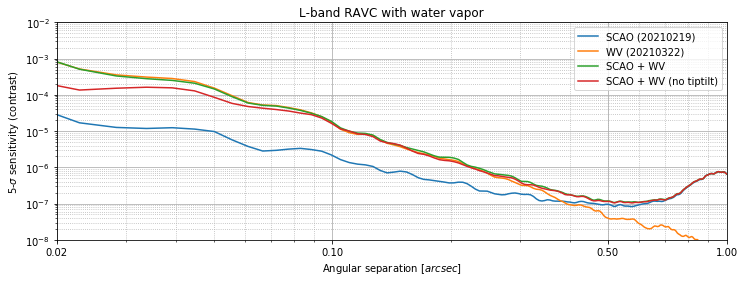

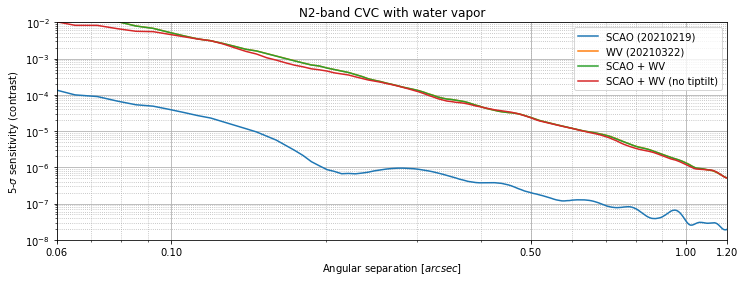

In [13]:
L_no = fits.getdata('/Users/cdelacroix/dox/METIS/METIS_HCI_HEEPS_simulations/water_vapor_seeing/old/cc_adi_bckg0_L_RAVC_fullM1_scao_only_water_vapor_no.fits')
L_only = fits.getdata('/Users/cdelacroix/dox/METIS/METIS_HCI_HEEPS_simulations/water_vapor_seeing/old/cc_adi_bckg0_L_RAVC_fullM1_scao_only_water_vapor_WVonly.fits')
L_yes = fits.getdata('/Users/cdelacroix/dox/METIS/METIS_HCI_HEEPS_simulations/water_vapor_seeing/old/cc_adi_bckg0_L_RAVC_fullM1_scao_only_water_vapor_yes.fits')
L_noTT = fits.getdata('/Users/cdelacroix/dox/METIS/METIS_HCI_HEEPS_simulations/water_vapor_seeing/old/cc_adi_bckg0_L_RAVC_fullM1_scao_only_water_vapor_noTT.fits')
N_no = fits.getdata('/Users/cdelacroix/dox/METIS/METIS_HCI_HEEPS_simulations/water_vapor_seeing/old/cc_adi_bckg0_N2_CVC_fullM1_scao_only_water_vapor_no.fits')
N_only = fits.getdata('/Users/cdelacroix/dox/METIS/METIS_HCI_HEEPS_simulations/water_vapor_seeing/old/cc_adi_bckg0_N2_CVC_fullM1_scao_only_water_vapor_WVonly.fits')
N_yes = fits.getdata('/Users/cdelacroix/dox/METIS/METIS_HCI_HEEPS_simulations/water_vapor_seeing/old/cc_adi_bckg0_N2_CVC_fullM1_scao_only_water_vapor_yes.fits')
N_noTT = fits.getdata('/Users/cdelacroix/dox/METIS/METIS_HCI_HEEPS_simulations/water_vapor_seeing/old/cc_adi_bckg0_N2_CVC_fullM1_scao_only_water_vapor_noTT.fits')
plt.figure(figsize=(12,4))
plt.plot(L_no[0], L_no[1], label='SCAO (20210219)')
plt.plot(L_only[0], L_only[1], label='WV (20210322)')
plt.plot(L_yes[0], L_yes[1], label='SCAO + WV')
plt.plot(L_noTT[0], L_noTT[1], label='SCAO + WV (no tiptilt)')
plt.title('L-band RAVC with water vapor')
plt.xlabel('Angular separation $[arcsec]$')
plt.ylabel('5-$\sigma$ sensitivity (contrast)')
plt.xlim(0.02, 1)
plt.ylim(1e-8,1e-2)
plt.grid(True), plt.grid(which='minor', linestyle=':')
plt.loglog(), plt.legend()
plt.xticks([0.02, 0.1, 0.5, 1])
plt.gca().xaxis.set_major_formatter(plt.ScalarFormatter())
plt.savefig('WV_L.png', transparent=True, dpi=300)
plt.figure(figsize=(12,4))
plt.plot(N_no[0], N_no[1], label='SCAO (20210219)')
plt.plot(N_only[0], N_only[1], label='WV (20210322)')
plt.plot(N_yes[0], N_yes[1], label='SCAO + WV')
plt.plot(N_noTT[0], N_noTT[1], label='SCAO + WV (no tiptilt)')
plt.title('N2-band CVC with water vapor')
plt.xlabel('Angular separation $[arcsec]$')
plt.ylabel('5-$\sigma$ sensitivity (contrast)')
plt.xlim(0.06, 1.2)
plt.ylim(1e-8,1e-2)
plt.grid(True), plt.grid(which='minor', linestyle=':')
plt.loglog(), plt.legend()
plt.xticks([0.06, 0.1, 0.5, 1, 1.2])
plt.gca().xaxis.set_major_formatter(plt.ScalarFormatter())
plt.savefig('WV_N2.png', transparent=True, dpi=300)

### new SCAO cube

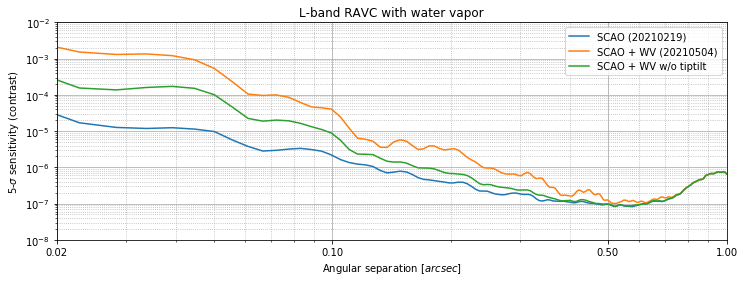

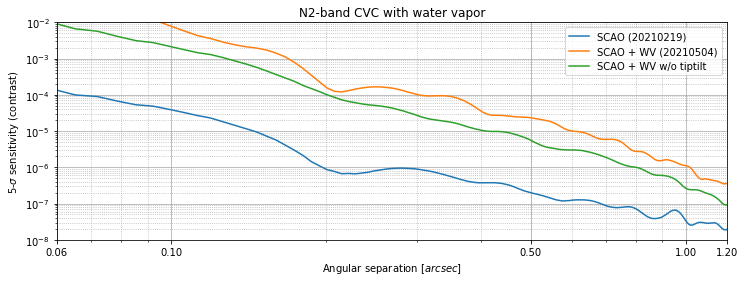

In [14]:
L_yes = fits.getdata('/Users/cdelacroix/dox/METIS/METIS_HCI_HEEPS_simulations/water_vapor_seeing/cc_adi_bckg0_L_RAVC_fullM1_scao_only_water_vapor_new_yes.fits')
L_noTT = fits.getdata('/Users/cdelacroix/dox/METIS/METIS_HCI_HEEPS_simulations/water_vapor_seeing/cc_adi_bckg0_L_RAVC_fullM1_scao_only_water_vapor_new_noTT.fits')
N_yes = fits.getdata('/Users/cdelacroix/dox/METIS/METIS_HCI_HEEPS_simulations/water_vapor_seeing/cc_adi_bckg0_N2_CVC_fullM1_scao_only_water_vapor_new_yes.fits')
N_noTT = fits.getdata('/Users/cdelacroix/dox/METIS/METIS_HCI_HEEPS_simulations/water_vapor_seeing/cc_adi_bckg0_N2_CVC_fullM1_scao_only_water_vapor_new_noTT.fits')
plt.figure(figsize=(12,4))
plt.plot(L_no[0], L_no[1], label='SCAO (20210219)')
plt.plot(L_yes[0], L_yes[1], label='SCAO + WV (20210504)')
plt.plot(L_noTT[0], L_noTT[1], label='SCAO + WV w/o tiptilt')
plt.title('L-band RAVC with water vapor')
plt.xlabel('Angular separation $[arcsec]$')
plt.ylabel('5-$\sigma$ sensitivity (contrast)')
plt.xlim(0.02, 1)
plt.ylim(1e-8,1e-2)
plt.grid(True), plt.grid(which='minor', linestyle=':')
plt.loglog(), plt.legend()
plt.xticks([0.02, 0.1, 0.5, 1])
plt.gca().xaxis.set_major_formatter(plt.ScalarFormatter())
plt.savefig('WV_L.png', transparent=True, dpi=300)
plt.figure(figsize=(12,4))
plt.plot(N_no[0], N_no[1], label='SCAO (20210219)')
plt.plot(N_yes[0], N_yes[1], label='SCAO + WV (20210504)')
plt.plot(N_noTT[0], N_noTT[1], label='SCAO + WV w/o tiptilt')
plt.title('N2-band CVC with water vapor')
plt.xlabel('Angular separation $[arcsec]$')
plt.ylabel('5-$\sigma$ sensitivity (contrast)')
plt.xlim(0.06, 1.2)
plt.ylim(1e-8,1e-2)
plt.grid(True), plt.grid(which='minor', linestyle=':')
plt.loglog(), plt.legend()
plt.xticks([0.06, 0.1, 0.5, 1, 1.2])
plt.gca().xaxis.set_major_formatter(plt.ScalarFormatter())
plt.savefig('WV_N2.png', transparent=True, dpi=300)